## 사이킷런으로 수행하는 타이타닉 생존자 예측 

**타이타닉 탑승자 데이터**
* Passengerid: 탑승자 데이터 일련번호
* survived: 생존 여부(0=사망, 1=생존)
* pclass: 티켓의 선실 등급(1=일등석, 2=이등석, 3=삼등석)
* sex: 탑승자 성별
* name: 탑승자 이름
* Age: 탑승자 나이
* sibsp: 같이 탑승한 형제자매 또는 배우자 인원수 
* parch: 같이 탑승한 부모님 또는 어린이 인원수
* ticket: 티켓 번호
* fare: 요금
* cabin: 선실 번호
* embarked: 중간 정착 항구(C=Cherbourg, Q=Queenstown, S=Southampton)


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

titanic_df = pd.read_csv('titanic_train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


* **칼럼 타입 확인**

In [3]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* **Null값 처리 - fillna()**   
Age는 평균 나이, 나머지 칼럼은 'N'값으로 변경한다.

In [6]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)
print('데이터 세트 Null 값 개수', titanic_df.isnull().sum().sum())

데이터 세트 Null 값 개수 0


* **문자열 피처: Sex, Cabin, Embarked - 값 분류 살펴보기**

In [9]:
print(titanic_df['Sex'].value_counts())

male      577
female    314
Name: Sex, dtype: int64


In [11]:
print(titanic_df['Embarked'].value_counts())

S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


In [10]:
print(titanic_df['Cabin'].value_counts())

N              687
G6               4
C23 C25 C27      4
B96 B98          4
D                3
              ... 
C46              1
A14              1
E50              1
D10 D12          1
E38              1
Name: Cabin, Length: 148, dtype: int64


Cabin(선실)의 경우 N이 687건으로 가장 많다. 속성값이 제대로 정리 되지 않은 것이 있다. 예를들어, 'C23 C25 C27'같이 여러 Cabin이 한꺼번에 표기된 Cabin 값이 4건이 된다. Cabin의 경우 선실 번호 중 선실 등급을 나타내는 첫 번째 알파벳이 중요해 보인다. Cabin 속성의 경우 앞 문자만 추출하겠다. 
* str(): 정수나 실수를 문자열 형태로 바꿔줌

In [19]:
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


### 어떤 유형의 승객이 생존 확률이 높았는지 분석  
**1) 성별에 따른 생존자 수 비교**

In [22]:
titanic_df.groupby(['Sex', 'Survived']).Survived.count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

Survivied 0은 사망, 1은 생존이다. 탑승객은 남자가 577명, 여자가 314명으로 남자가 더 많았다. 여자는 314명 중 233명으로 약 74.2%가 생존했지만, 남자의 경우에는 577명 중 468명이 죽고 109명만 살아남아 약 18.8%가 생존했다.

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

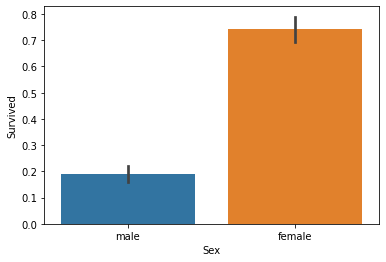

In [23]:
sns.barplot(x='Sex', y='Survived', data=titanic_df)

**2) 부자와 가난한 사람 간의 생존 확률 - 객실 등급별 생존 확률**

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

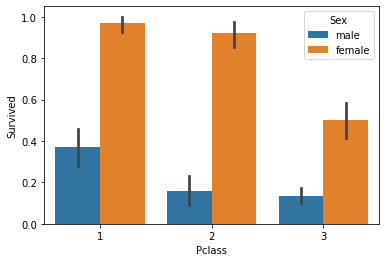

In [24]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

여성의 경우 일, 이등실에 따른 생존 확률의 차이는 크지 않으나, 삼등실의 경우 생존 확률이 상대적으로 많이 떨어진다. 남성의 경우 일등실의 생존 확률이 이, 삼등실의 생존 확률보다 월등히 높다.

**3) 나이에 따른 생존 확률**
* Age는 값 종류가 많기 때문에 범위별로 분류해 카테고리 값을 할당한다. 

In [28]:
def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else: cat = 'Elderly'
        
    return cat

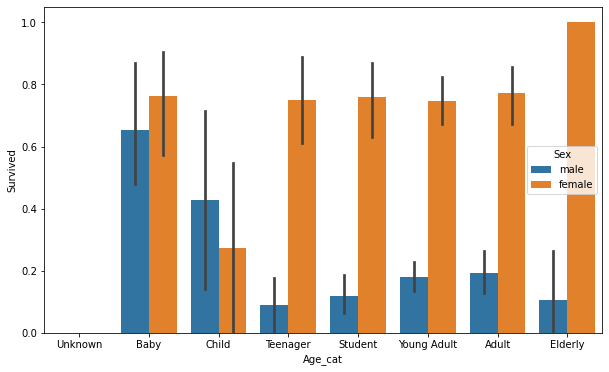

In [30]:
# 막대 그래프의 크기 figure을 더 크게 설정
plt.figure(figsize=(10, 6))

# X축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category() 함수를 반환값으로 지정
# get_category(X)는 입력값으로 'Age' 칼럼 값을 받아서 해당하는 cat 반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x: get_category(x))
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True)

여자 Baby의 경우 비교적 생존 확률이 높다. 여자 Child의 경우 다른 연령대에 비해 생존 확률이 낮다. 여자 Elderly의 경우 생존 확률이 매우 높다. 이제까지 분석한 결과 Sex, Age, PClass 등이 중요하게 생존을 좌우는 피처임을 확인할 수 있었다.




* **남아있는 문자열 카테고리 피처를 숫자형 카테고리 피처로 변환하기 - Sex, Cabin, Embarked**
 * 레이블 인코딩 적용: 카테고리 값의 유형 수에 따라 0 ~ (카테고리 유형 수-1)까지의 숫자 값으로 변환함

In [16]:
# 여러 칼럼을 encode_features() 함수를 새로 생성해 한 번에 변환하기
from sklearn import preprocessing 

def encode_features(dataDF):
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,147,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,81,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,147,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,55,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,147,2


Sex, Cabin, Embarked 속성이 숫자형으로 바뀌었다.

* 데이터 전처리를 전체적으로 호출하는 함수 만들기 - Null 처리, 포매팅, 인코딩하는 내부 함수 구성

In [21]:
# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

* 데이터 전처리를 수행하는 transform_features() 함수를 이용해 다시 원본 데이터 가공해보기   
 - 타이타닉 생존자 데이터 세트의 레이블인 Survivied 속성만 별도 분리해 클래스 결정값 데이터 세트로 만들기   
 - Survived 속성을 드롭해 피처 데이터 세트를 만들기    
 - 생성된 피처 데이터 세트에 transform_features()를 적용해 데이터 가공하기


In [22]:
# 원본 데이터를 재로딩하고, 피처 데이터 세트와 레이블 데이터 세트 추출
titanic_df = pd.read_csv('titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

X_titanic_df = transform_features(X_titanic_df)

* 내려받은 학습 데이터 세트를 기반으로 해서 train_test_split() API를 이용해 별도의 테스트 데이터 세ㅌ를 추출한다.  
테스트 데이터 세트 크기는 전체의 20%로 한다.

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, 
                                                   test_size=0.2, random_state=11)

* 사이킷런 클래스를 이용해 분리한 학습 데이터와 테스트 데이터를 기반으로 머신러닝 모델을 학습하고(fit), 예측(predict)하기   
예측 성능 평가는 정확도로 할 것이며 이를 위해 accuracy_score() API를 사용한다.

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [25]:
# 결정트리, RandomForest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도: 0.7877
RandomForestClassifier 정확도: 0.8547
LogisticRegression 정확도: 0.8492


C:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


3개의 알고리즘 중 RandomForestClassifier이 타 알고리즘에 비해 높은 정확도를 나타내고 있다. 아직 최적화 작업을 수행하지 않았고, 데이터 양도 충분하지 않기 때문에 어떤 알고리즘이 가장 성능이 좋다고 평가할 수는 없다. 

* 교차 검증으로 결정 트리 모델을 평가해보기    
교차 검증을 위한 사이킷런 model_selection 패키지의 KFold 클래스, cross_val_score(), GridSearchCV 클래스를 모두 사용한다. 먼저 사이킷런의 KFold 클래스를 이용해 교차 검증을 수행하며, 폴드 개수는 5개로 설정한다.

In [26]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
    # 폴드 세트를 5개인 KFold 객체를 생성, 폴드 수만큼 예측결과 저장을 위한 리스트 객체 생성
    kfold = KFold(n_splits=folds)
    scores = []
    
    # KFold 교차 검증을 수행.
    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        # Classifier 학습, 예측, 정확도 계산
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print('교차 검증 {0} 정확도: {1:.4f}'.format(iter_count, accuracy))
        
    # 5개의 fold에서의 평균 정확도 계산
    mean_score = np.mean(scores)
    print('평균 정확도: {0:.4f}'.format(mean_score))
# exec_kfold 호출
exec_kfold(dt_clf, folds=5)

교차 검증 0 정확도: 0.7542
교차 검증 1 정확도: 0.7809
교차 검증 2 정확도: 0.7865
교차 검증 3 정확도: 0.7697
교차 검증 4 정확도: 0.8202
평균 정확도: 0.7823


평균 정확도는 약 78.23%이다. 

* 교차 검증을 cross_val_score() API를 이용해 수행하기

In [27]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)
for iter_count, accuracy in enumerate(scores):
    print('교차 검증 {0} 정확도: {1:.4f}'.format(iter_count, accuracy))
    
print('평균 정확도: {0:.4f}'.format(np.mean(scores)))

교차 검증 0 정확도: 0.7430
교차 검증 1 정확도: 0.7753
교차 검증 2 정확도: 0.7921
교차 검증 3 정확도: 0.7865
교차 검증 4 정확도: 0.8427
평균 정확도: 0.7879


평균 정확도는 78.79%이다. cross_val_score()가 StratifiedKFold를 이용해 폴드 세트를 분할하기 때문에 K 폴드의 평균 정확도와 약간 다르다.

* GridSearchCV를 이용해 DecisionTreeClassifier의 최적 하이퍼 파라미터를 찾고 예측 성능을 측정하기   
CV는 5개의 폴드 세트를 지정하고 하이퍼 파라미터는 max_depth, min_samples_split, min_samples_leaf를 변경하면서 성능을 측정한다. 
최적 하이퍼 파라미터와 그때의 예측을 출력하고, 최적 하이퍼 파라미터로 학습된 Estimator를 이용해 위의 train_test_split()으로 분리된 테스트 데이터 세트에 예측을 수행해 예측 정확도를 출력하겠다.


In [28]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': [2, 3, 5, 10],
              'min_samples_split': [2, 3, 5], 'min_samples_leaf': [1, 5, 8]}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터:', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy))


GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도: 0.8715


최적화된 하이퍼 파라미터로 DecisionTreeClassifier를 학습시킨 뒤 예측 정확도가 약 87.15%로 향상됐다. 하이퍼 파라미터 변경 전보다 약 8% 이상이 증가했는데, 일반적으로 하이퍼 파라미터를 튜닝하더라도 이 정도 수준으로 증가하기는 매우 어렵다. 테스트용 데이터 세트가 작기 때문에 수치상으로 예측 성능이 많이 증가한 것으로 보인다.

## 정리
* 머신러닝 모델은 학습 데이터 세트로 학습한 뒤 반드시 별도의 테스트 데이터 세트로 평가되어야 한다.  
* 테스트 데이터의 건수 부족이나 고정된 테스트 데이터 세트를 이용한 반복적인 모델의 학습과 평가는 해당 테스트 데이터 세트에만 치우친 빈약한 머신러닝 모델을 만들 가능성이 높다.    
* 이를 해결하기 위해 학습 데이터 세트를 학습 데이터와 검증 데이터로 구성된 여러 개의 폴드 세트로 분리해 교차 검증을 수행할 수 있다. 사이킷런은 이러한 교차 검증을 지원하기 위해 KFold, StratifiedKFold, cross_val_score() 등의 다양한 클래스와 함수를 제공한다. 
* 또한, 머신러닝 모델의 최적의 하이퍼 파라미터를 교차 검증을 통해 추출하기 위해 GridSearchCV를 제공한다.
